In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from adopt import ADOPT
from torch.optim import AdamW
import gc

In [2]:
chunksize = 200000
chunks = []

# Iterating over chunks
for chunk in pd.read_json('../dataset/dataset.json', lines=True, chunksize=chunksize):
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

df.head()

,reviewerID,asin,reviewerName,verified,reviewText,overall,reviewTime,summary,unixReviewTime,style,vote,image
0,A1H1DL4K669VQ9,0001393774,Judith Paladino,True,Love it!! Great seller!,5,"04 29, 2016",Five Stars,1461888000,NaN,NaN,NaN
1,A3V5XBBT7OZG5G,0001393774,gflady,True,One of my very favourite albums from one of my...,5,"02 23, 2016",One of my very favourite albums from one of my...,1456185600,NaN,NaN,NaN
2,A3SNL7UJY7GWBI,0001393774,Lady Leatherneck,True,"THank you Jesus Lord God, that brother Green's...",5,"02 11, 2016",Five Stars,1455148800,NaN,NaN,NaN
3,A3478QRKQDOPQ2,0001393774,jacki,True,I recall loving his other albums and maybe thi...,5,"11 28, 2015",forgot but I figured on some of these artists ...,1448668800,NaN,NaN,NaN
4,A23M5VTSN2C3H1,0001393774,Caliope,True,Keith Green was a pioneer in the field of Chri...,5,"12 16, 2014",and I have loved every album he did,1418688000,NaN,NaN,NaN


In [3]:
# defining functions here
def clean_data(df):
    df.drop(columns=['reviewerName', 'verified', 'reviewTime', 'summary', 'unixReviewTime', 'style', 'vote', 'image'], inplace=True)
    df.dropna(subset=['reviewText'], inplace=True)
    #df.fillna({'vote': 1}, inplace=True)
    
def preprocess(data):
    label_encoder = LabelEncoder()
    data.loc[:, 'reviewerID'] = label_encoder.fit_transform(data['reviewerID'])
    data.loc[:, 'asin'] = label_encoder.fit_transform(data['asin'])
    
def train_test_split(df, test_size=0.2):
    indices = df.index.tolist()
    test_indices = np.random.choice(indices, size=int(len(df)*test_size), replace=False)
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

def split_user_group(group):
    group = group.sample(frac=1).reset_index(drop=True)

    train = group.iloc[:3]
    test = group.iloc[3:5]
    
    return train, test

In [4]:
clean_data(df)
df.isna().sum()

reviewerID    0
asin          0
reviewText    0
overall       0
dtype: int64

In [5]:
# saving dataset 
df.to_csv('../dataset/cleaned_dataset.csv', index=False)

In [5]:
user_review_counts = df.groupby('reviewerID').size()
df_filtered = df[df['reviewerID'].isin(user_review_counts[user_review_counts >= 5].index)]

unique_users = df_filtered['reviewerID'].unique()
sampled_users = np.random.choice(unique_users, size=1000, replace=False)
df_sampled = df_filtered[df_filtered['reviewerID'].isin(sampled_users)]

preprocess(df_sampled)
num_users = df_sampled['reviewerID'].nunique()
num_items = df_sampled['asin'].nunique()

train_list = []
test_list = []

for user_id, group in df_sampled.groupby('reviewerID'):
    group = group.sample(frac=1).reset_index(drop=True)

    train = group.iloc[:3]
    test = group.iloc[3:5]
    
    train_list.append(train)
    test_list.append(test)
    
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

print(f'Train set size: {len(train_df)}')
print(f'Test set size: {len(test_df)}')

del df
del df_sampled
gc.collect()

Train set size: 3000
Test set size: 2000


0

In [6]:
train_df.head()

,reviewerID,asin,overall
0,0,3747,4
1,0,1181,4
2,0,2481,5
0,1,7398,5
1,1,5089,5


In [7]:
class AmazonRatingsDataset(Dataset):
    def __init__(self, df):
        self.user_ids = df['reviewerID'].values
        self.item_ids = df['asin'].values
        self.ratings = df['overall'].values

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return {
            'user_id': torch.tensor(self.user_ids[idx], dtype=torch.long),
            'item_id': torch.tensor(self.item_ids[idx], dtype=torch.long),
            'rating': torch.tensor(self.ratings[idx], dtype=torch.long)
        }

In [127]:
train_dataset = AmazonRatingsDataset(train_df)
test_dataset = AmazonRatingsDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [126]:
class Model(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=8):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim*2, 64)
        self.fc2 = nn.Linear(64, 5)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, user, item):
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        x = torch.cat([user_embedding, item_embedding], dim=-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [128]:
targets = train_df['overall'].values
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

model = Model(num_users, num_items)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-1)

Epoch 1/50, Train Loss: 1.6447231287651873, Test Loss: 1.6088321909071908, Train Accuracy: 0.227, Test Accuracy: 0.311
Epoch 2/50, Train Loss: 1.6169130928972935, Test Loss: 1.6058078739378188, Train Accuracy: 0.30033333333333334, Test Accuracy: 0.3975
Epoch 3/50, Train Loss: 1.5974914101844138, Test Loss: 1.6059013075298734, Train Accuracy: 0.336, Test Accuracy: 0.322
Epoch 4/50, Train Loss: 1.5837757194295843, Test Loss: 1.6059322073346092, Train Accuracy: 0.30833333333333335, Test Accuracy: 0.3185
Epoch 5/50, Train Loss: 1.560644303230529, Test Loss: 1.6058582162100172, Train Accuracy: 0.30133333333333334, Test Accuracy: 0.386
Epoch 6/50, Train Loss: 1.5537801701971825, Test Loss: 1.6103243657520838, Train Accuracy: 0.3446666666666667, Test Accuracy: 0.288
Epoch 7/50, Train Loss: 1.547017680837753, Test Loss: 1.61397599795508, Train Accuracy: 0.3333333333333333, Test Accuracy: 0.3515
Epoch 8/50, Train Loss: 1.5272871788511886, Test Loss: 1.6144552647121369, Train Accuracy: 0.3613333

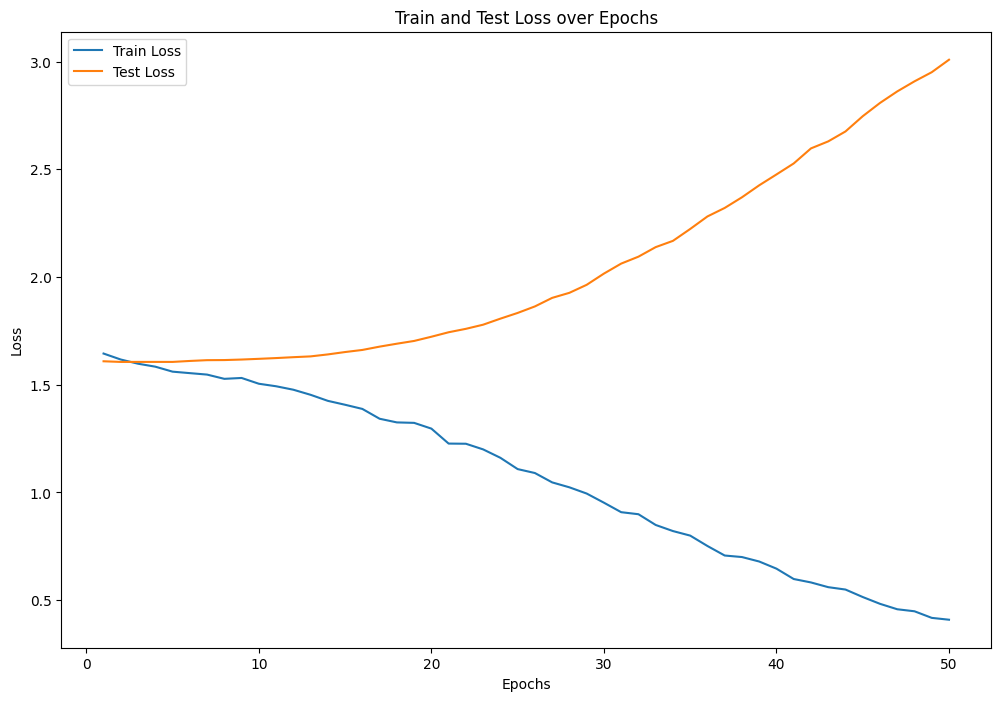

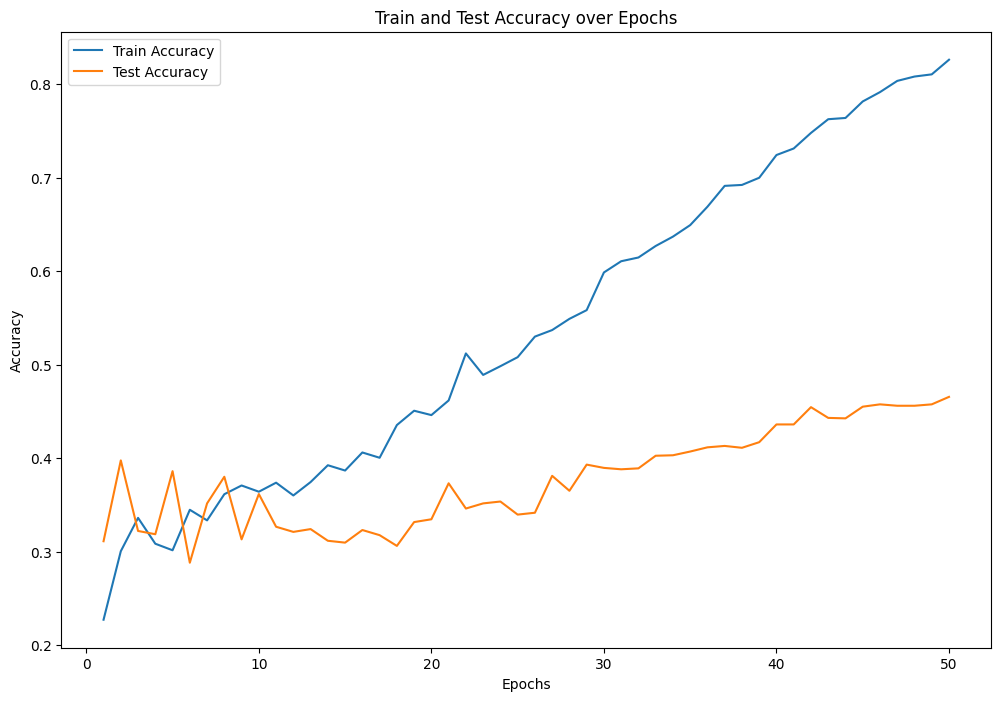

In [129]:
EPOCHS = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for batch in train_loader:
        user = batch['user_id']
        item = batch['item_id']
        rating = batch['rating'] - 1
        
        optimizer.zero_grad()
        output = model(user, item)
        loss = criterion(output, rating)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == rating).sum().item()
        total_train += rating.size(0)
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)
    
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch in test_loader:
            user = batch['user_id']
            item = batch['item_id']
            rating = batch['rating'] - 1
            
            output = model(user, item)
            loss = criterion(output, rating)
            test_loss += loss.item()
            
            _, predicted = torch.max(output, 1)
            correct_test += (predicted == rating).sum().item()
            total_test += rating.size(0)
    
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)
    
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss / len(train_loader)}, Test Loss: {test_loss / len(test_loader)}, Train Accuracy: {correct_train / total_train}, Test Accuracy: {correct_test / total_test}')

# Plotting Loss
plt.figure(figsize=(12, 8))
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss over Epochs')
plt.show()

# Plotting Accuracy
plt.figure(figsize=(12, 8))
plt.plot(range(1, EPOCHS+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy over Epochs')
plt.show()

In [101]:
# priting some preds from test vs actual values
model.eval()
with torch.no_grad():
    for batch in test_loader:
        user = batch['user_id']
        item = batch['item_id']
        rating = batch['rating']-1
        
        output = model(user, item)
        output = F.softmax(output, dim=-1)
        preds = torch.argmax(output, dim=-1)
        
        print('Predictions:', preds)
        print('Actual:', rating)
        break

Predictions: tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
Actual: tensor([3, 3, 4, 4, 4, 4, 4, 3, 4, 3, 0, 3, 4, 4, 4, 3, 3, 0, 3, 3, 4, 4, 3, 3,
        3, 4, 4, 3, 4, 3, 4, 4, 4, 3, 2, 2, 4, 1, 0, 4, 4, 4, 3, 4, 0, 3, 4, 3,
        4, 2, 4, 4, 4, 4, 3, 3, 4, 4, 1, 3, 3, 3, 4, 4])
